### Import packages

In [12]:
# general
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# modelling stuff 
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical, np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
import keras.callbacks
from keras.preprocessing.image import ImageDataGenerator
from keras.wrappers.scikit_learn import KerasClassifier


### Read the data

In [95]:
with open('shipsnet.json') as data_file:
    dataset = json.load(data_file)
Shipsnet= pd.DataFrame(dataset)
print(Shipsnet.head())
print('')
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of NoShip Images: {}'.format(np.sum(b==0)))
    print('Number of Ship Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(x,y)


                                                data  labels  \
0  [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...       1   
1  [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...       1   
2  [125, 127, 129, 130, 126, 125, 129, 133, 132, ...       1   
3  [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...       1   
4  [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...       1   

                                   locations             scene_ids  
0    [-118.2254694333423, 33.73803725920789]  20180708_180909_0f47  
1    [-122.33222866289329, 37.7491755586813]  20170705_180816_103e  
2  [-118.14283073363218, 33.736016066914175]  20180712_211331_0f06  
3   [-122.34784341495181, 37.76648707436548]  20170609_180756_103a  
4   [-122.34852408322172, 37.75878462398653]  20170515_180653_1007  

Total number of images: 4000
Number of NoShip Images: 3000
Number of Ship Images: 1000
Percentage of positive images: 25.00%
Image shape (Width, Height, Channels): (19200,)


### Data reshape

In [15]:
xReshaped = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
yReshaped = to_categorical(y, num_classes=2)
print("Data Shape",x.shape)
print('Labels Shape',y.shape)
print('Reshaped Data Shape',xReshaped.shape)
print('Reshaped Labels Shape',yReshaped.shape)
def describeDataset(features,labels):
    print("\n'X' shape: %s."%(features.shape,))
    print("\n'y' shape: %s."%(labels.shape,))
    print("\nUnique elements in y: %s"%(np.unique(y)))
describeDataset(xReshaped,yReshaped)

Data Shape (4000, 19200)
Labels Shape (4000,)
Reshaped Data Shape (4000, 80, 80, 3)
Reshaped Labels Shape (4000, 2)

'X' shape: (4000, 80, 80, 3).

'y' shape: (4000, 2).

Unique elements in y: [0 1]


### Display sample images

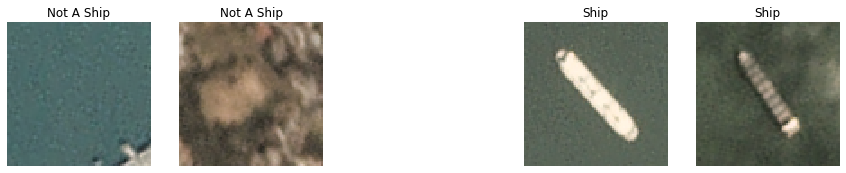

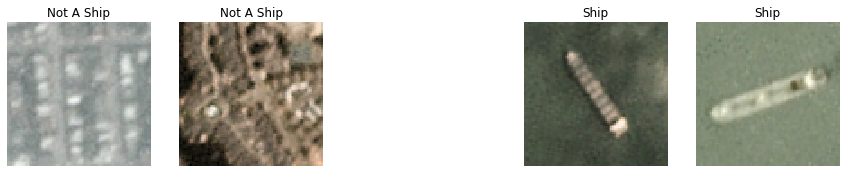

In [16]:
imgs0 = xReshaped[y==0] 
imgs1 = xReshaped[y==1] 

def plotTwo(a,b):
    for row in range(2):
        plt.figure(figsize=(18,18))
        for col in range(2):
            plt.subplot(1,6,col+1)
            plt.title('Not A Ship')
            plt.imshow(a[20*row+col])
            plt.axis('off')       
            plt.subplot(1,6,col+4)
            plt.title('Ship')
            plt.imshow(b[row+col])
            plt.axis('off')

plotTwo(imgs0, imgs1)


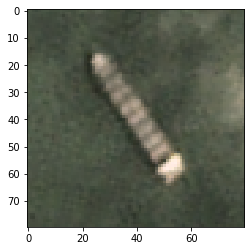

In [17]:
plt.imshow(imgs1[1])

In [18]:
dist = pd.Series([len(imgs0)],index=['No Ship' ])

dist['Ship'] = len(imgs1)

In [19]:
dist

No Ship    3000
Ship       1000
dtype: int64

### Target distribution

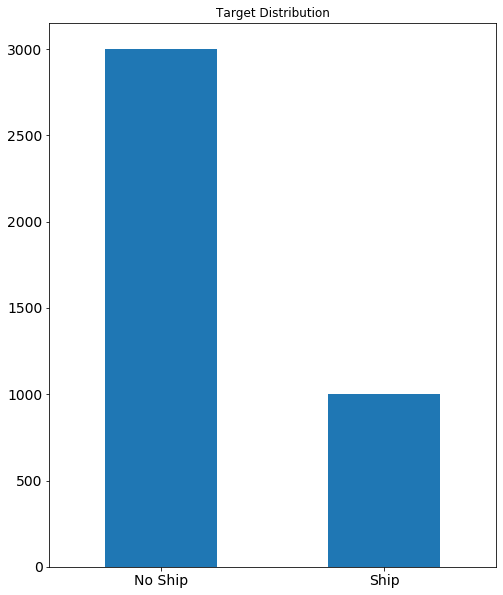

In [20]:
plt.figure(figsize=(8,10))

dist.plot.bar()
plt.xticks(rotation=0,fontsize=14)
plt.yticks(rotation=0,fontsize=14)
plt.title('Target Distribution')
plt.show()

### Train-test split

In [21]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2 ,random_state = 42)
x_trainReshaped,x_testReshaped,y_trainReshaped,y_testReshaped = train_test_split(xReshaped,yReshaped,test_size = 0.2 ,random_state = 42)



### Machine Learning Models with Cross Validation


In [22]:
%%time 

a,b,c,d = x_train,y_train,x_test,y_test 
print('\nCompare Multiple Classifiers:')
print('\nK-Fold Cross-Validation Accuracy:\n')
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('XGB', XGBClassifier()))
resultsAccuracy = []
names = []

for name, model in models:
    model.fit(a,b)
    kfold = model_selection.KFold(n_splits=5)
    accuracy_results = model_selection.cross_val_score(model, a,b, cv=kfold, scoring='accuracy',n_jobs=-1)
    resultsAccuracy.append(accuracy_results)
    names.append(name)
    accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
    print(accuracyMessage)



Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:



/Users/gandharkamat/projects/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR: 0.891875 (0.014059)
RF: 0.951562 (0.008949)
KNN: 0.923750 (0.009396)
SVM: 0.964375 (0.003617)
DTC: 0.898125 (0.011751)
XGB: 0.953750 (0.006746)
CPU times: user 7min 25s, sys: 7.26 s, total: 7min 32s
Wall time: 18min 55s


In [23]:
resultsAccuracy

[array([0.8765625, 0.9140625, 0.8796875, 0.8875   , 0.9015625]),
 array([0.953125 , 0.9375   , 0.946875 , 0.95625  , 0.9640625]),
 array([0.9171875, 0.921875 , 0.9109375, 0.9328125, 0.9359375]),
 array([0.9609375, 0.96875  , 0.959375 , 0.965625 , 0.9671875]),
 array([0.8953125, 0.878125 , 0.903125 , 0.9      , 0.9140625]),
 array([0.9421875, 0.953125 , 0.953125 , 0.9578125, 0.9625   ])]

### Deep Learning (CNN) with Cross validation

In [24]:
%%time

indexes = np.arange(4000)
np.random.shuffle(indexes)

X_train_d = x[indexes].reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
X_train_d = X_train_d / 255
y_train = y[indexes]

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
    model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=sgd,
        metrics=['accuracy'])
    
    return model
    
model = KerasClassifier(build_fn=create_model, batch_size=32,
    epochs=18,
    shuffle=True,
    verbose=1
)

results = model_selection.cross_val_score(model, X_train_d, y_train, cv=skf, scoring='accuracy',n_jobs=-1)


CPU times: user 992 ms, sys: 629 ms, total: 1.62 s
Wall time: 24min 11s


In [25]:
results

array([0.9925 , 0.9925 , 0.9825 , 0.98375, 0.97875])

In [26]:
np.average([0.9925, 0.9825, 0.9925, 0.975 , 0.9875, 0.98  , 0.985 , 0.9875,
       0.9825, 0.9875])

0.9852500000000001

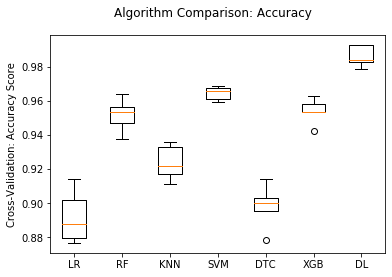

In [27]:
res = resultsAccuracy[0:6]
res.append(results)

nam = names[0:6]
nam.append('DL')

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(res)
ax.set_xticklabels(nam)
ax.set_ylabel('Cross-Validation: Accuracy Score')
plt.show()


### PCA + Deep Learning (CNN) with Cross validation


In [28]:
pca = PCA().fit(x)

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.,
        4000., 4500.]), <a list of 11 Text xticklabel objects>)

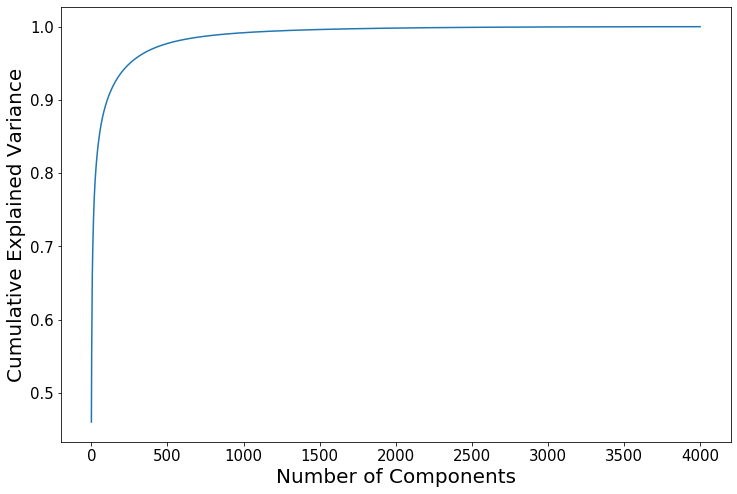

In [29]:
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components',fontsize=20)
plt.ylabel('Cumulative Explained Variance',fontsize=20)
plt.yticks(fontsize=15, rotation=0)
plt.xticks(fontsize=15, rotation=0)

In [30]:
# PCA for input - (4000,19200)
X_pca = PCA(n_components=1200)
X_pca.fit(x)
components = X_pca.transform(x)
components.shape

(4000, 1200)

In [31]:
components

array([[ 4.28308072e+02,  2.59892750e+03, -1.71006681e+03, ...,
         8.16216883e+00, -1.29076072e+01,  1.68578552e+01],
       [-3.26315649e+03, -1.09689252e+02, -4.39133141e+02, ...,
         2.05733121e+01,  1.95522435e+01, -2.22846667e+01],
       [ 4.35488176e+03, -3.72542421e+02,  4.48315685e+02, ...,
         5.84695546e+00, -1.23510276e+01, -7.70368580e+00],
       ...,
       [ 6.68455402e+02,  4.02847576e+02,  9.69187735e-01, ...,
         3.50753588e+01, -8.61696226e-01, -3.08294035e+01],
       [-3.45433739e+02, -5.20500181e+02, -2.09187301e+02, ...,
         8.91453615e+00, -1.14930255e+01, -6.37942214e+00],
       [-2.35760916e+03,  1.63992614e+03,  1.30641992e+03, ...,
        -2.29851892e+01,  6.31406908e+00,  3.23366281e+00]])

In [64]:
%%time

indexes = np.arange(4000)
np.random.shuffle(indexes)

X_train_d = components[indexes].reshape([-1, 3, 20, 20]).transpose([0,2,3,1])
X_train_d = X_train_d / 255
y_train = y[indexes]

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(20, 20, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
    model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=sgd,
        metrics=['accuracy'])
    
    return model

model = KerasClassifier(build_fn=create_model, batch_size=32,
    epochs=18,
    shuffle=True,
    verbose=1)

results_pca = model_selection.cross_val_score(model, X_train_d, y_train, cv=skf, scoring='accuracy', n_jobs=-1)


CPU times: user 121 ms, sys: 129 ms, total: 250 ms
Wall time: 1min 31s


In [66]:
y_train

array([1, 0, 1, ..., 1, 0, 1], dtype=uint8)

### Comparison plot

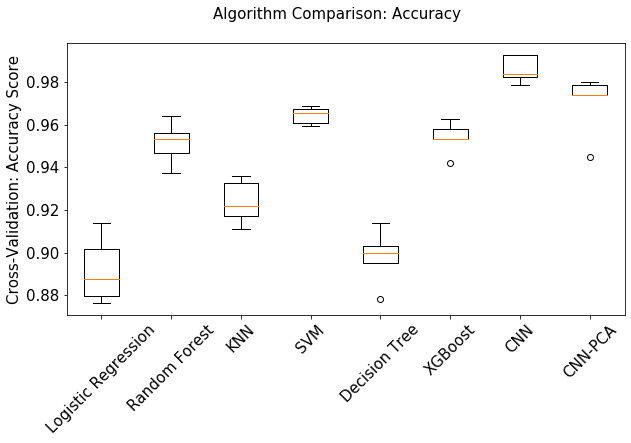

In [49]:
res1 = res[0:7]
res1.append(results_pca)

nam1 = nam[0:7]
nam1.append('DL-PCA')
nam1=['Logistic Regression','Random Forest','KNN','SVM','Decision Tree','XGBoost','CNN','CNN-PCA']
# boxplot algorithm comparison
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithm Comparison: Accuracy',fontsize=15)
ax = fig.add_subplot(111)
plt.boxplot(res1)
ax.set_xticklabels(nam1,fontsize=15,rotation=45)
ax.set_ylabel('Cross-Validation: Accuracy Score',fontsize=15)
plt.yticks(fontsize=15, rotation=0)
plt.show()


### Final model for prediction

In [96]:
indexes = np.arange(4000)
np.random.shuffle(indexes)

X_train_d = x[indexes].reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
X_train_d = X_train_d / 255
y_train = y[indexes]


In [97]:
X_train_d.shape

(4000, 80, 80, 3)

In [98]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

model.fit(
    X_train_d, 
    y_train,
    batch_size=32,
    epochs=18,
    validation_split=0.2,
    shuffle=True,
    verbose=1)
# X_train_d.shape

Train on 3200 samples, validate on 800 samples
Epoch 1/18
3200/3200 [==============================] - 15s 5ms/step - loss: 0.4364 - accuracy: 0.8022 - val_loss: 0.2790 - val_accuracy: 0.8900
Epoch 2/18
3200/3200 [==============================] - 17s 5ms/step - loss: 0.2338 - accuracy: 0.9053 - val_loss: 0.1636 - val_accuracy: 0.9350
Epoch 3/18
3200/3200 [==============================] - 17s 5ms/step - loss: 0.1678 - accuracy: 0.9291 - val_loss: 0.1628 - val_accuracy: 0.9275
Epoch 4/18
3200/3200 [==============================] - 18s 5ms/step - loss: 0.1270 - accuracy: 0.9497 - val_loss: 0.0974 - val_accuracy: 0.9663
Epoch 5/18
3200/3200 [==============================] - 17s 5ms/step - loss: 0.1023 - accuracy: 0.9625 - val_loss: 0.0718 - val_accuracy: 0.9762
Epoch 6/18
3200/3200 [==============================] - 17s 5ms/step - loss: 0.0820 - accuracy: 0.9709 - val_loss: 0.1189 - val_accuracy: 0.9525
Epoch 7/18
3200/3200 [==============================] - 17s 5ms/step - loss: 0.0803

### Load a satellite image of a San-Francisco bay area

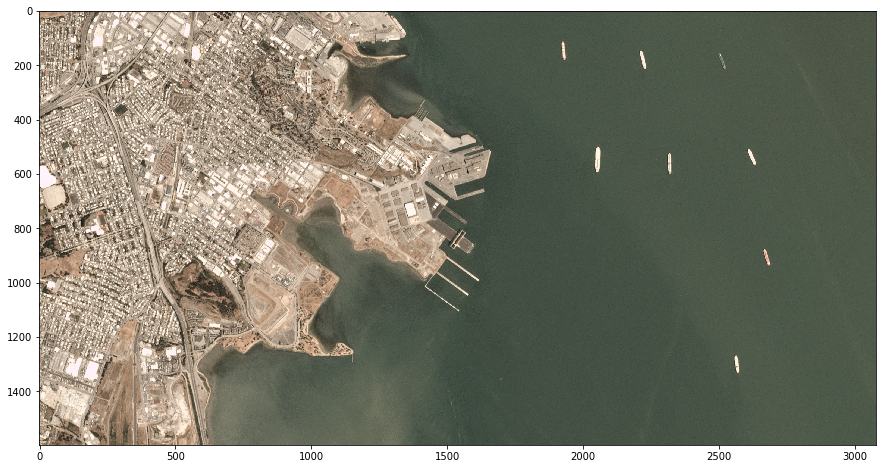

In [99]:
from PIL import Image
import sys

image = Image.open('scenes/scenes/sfbay_2.png')
pix = image.load()
n_spectrum = 3
width = image.size[0]
height = image.size[1]
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])
picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)
plt.figure(1, figsize = (15, 30))

plt.subplot(3, 1, 1)
plt.imshow(picture_tensor)

plt.show()

### Identify ships and their coordinates in satellite image

X:1890 Y:100  [[6.5008884e-05 9.4383168e-01]]


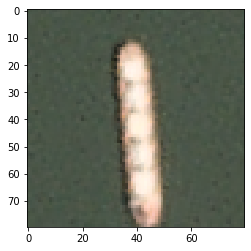

X:2180 Y:140  [[3.6702177e-06 9.5172662e-01]]


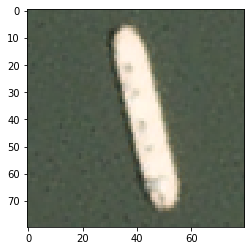

X:2580 Y:500  [[7.0028165e-07 9.4347966e-01]]


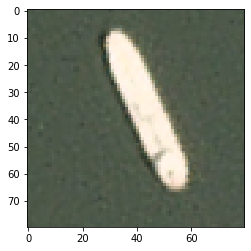

X:2280 Y:520  [[4.713668e-05 9.584493e-01]]


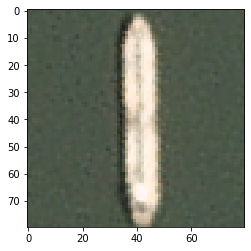

X:2640 Y:870  [[1.4447953e-07 9.9787831e-01]]


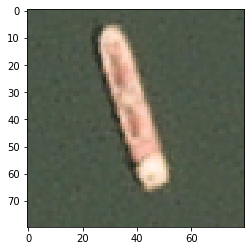

X:2530 Y:1260  [[1.4359233e-05 9.7024912e-01]]


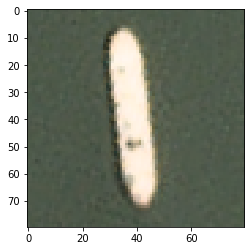

X:3000 Y:1510  

In [100]:
picture_tensor = picture_tensor.transpose(2,0,1)

def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result
def show_ship(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1
step = 10; coordinates = []

for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()
            

In [101]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])
#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape

(1597, 3081, 3)

### Mark the ships with boxes in the satellite image

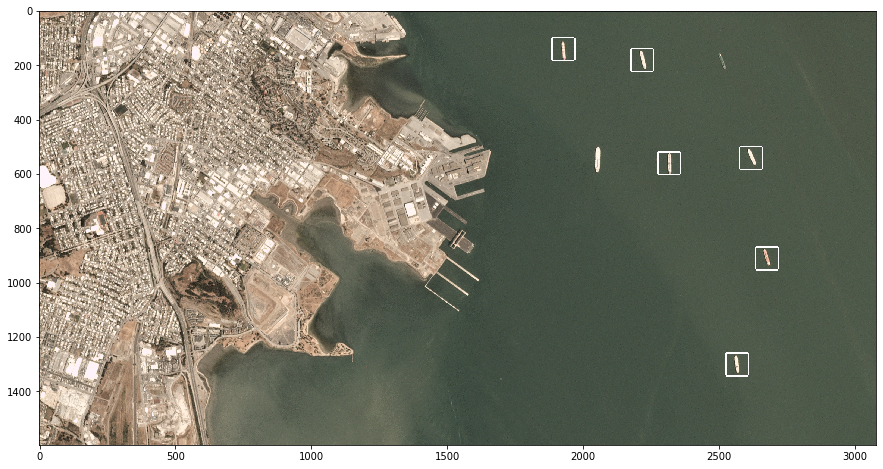

In [102]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()